In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [2]:
labelPath = r"E:\cancer\labels"
labelList = os.listdir(labelPath)
pos_w = []
pos_h = []
roi_h = []
roi_w = []
for name in labelList:
    path =os.path.join(labelPath, name)
    with open(path, 'r') as f:
        js = json.load(f)
    for info in js:
        if info["class"] == "roi":
            roi_h.append(info["h"])
            roi_w.append(info["w"])
        elif info["class"] == "pos":
            pos_h.append(info["h"])
            pos_w.append(info["w"])
        else:print(name)

ratio_roi = [h/w for h,w in zip(roi_h,roi_w)]
ratio_pos = [h/w for h,w in zip(pos_h,pos_w)]

In [3]:
print("roi:\n max_w = %d\n min_w = %d\n mean_w = %.2f\n max_h = %d\n min_h = %d\n mean_h = %.2f"%(
    np.max(roi_w), np.min(roi_w), np.mean(roi_w), np.max(roi_h), np.min(roi_h), np.mean(roi_h)))
print(" max_ratio = %.2f\n min__ratio = %.2f\n mean__ratio = %.2f\n"%(np.max(ratio_roi), np.min(ratio_roi), np.mean(ratio_roi)))

print("pos:\n max_w = %d\n min_w = %d\n mean_w = %.2f\n max_h = %d\n min_h = %d\n mean_h = %.2f"%(
    np.max(pos_w), np.min(pos_w), np.mean(pos_w), np.max(pos_h), np.min(pos_h), np.mean(pos_h)))
print(" max_ratio = %.2f\n min__ratio = %.2f\n mean__ratio = %.2f\n"%(np.max(ratio_pos), np.min(ratio_pos), np.mean(ratio_pos)))

roi:
 max_w = 26720
 min_w = 1339
 mean_w = 5344.28
 max_h = 19821
 min_h = 1339
 mean_h = 4796.88
 max_ratio = 2.63
 min__ratio = 0.31
 mean__ratio = 0.92

pos:
 max_w = 596
 min_w = 17
 mean_w = 123.76
 max_h = 577
 min_h = 15
 mean_h = 123.61
 max_ratio = 4.27
 min__ratio = 0.21
 mean__ratio = 1.06



In [4]:
def draw_distribution(pos_w, pos_h, base_w, base_h, knn_w=None, knn_h=None):
    fig = plt.figure()
    # 将画图窗口分成1行1列，选择第一块区域作子图
    ax1 = fig.add_subplot(1, 1, 1)
    # 设置标题
    ax1.set_title('Result Analysis')
    # 设置横坐标名称
    ax1.set_xlabel('width')
    # 设置纵坐标名称
    ax1.set_ylabel('height')
    # 画散点图
    ax1.scatter(pos_w, pos_h, s=25, marker='.')
    # 显示
    ax1.scatter(base_w, base_h, s=25,c = 'r', marker='.')
    if knn_w is not None:ax1.scatter(knn_w, knn_h, s=25,c = 'g', marker='.')
    plt.show()

In [5]:
def knnSeekAnchor(hw,anchor_num = 9,iter_num = 50):
    max_h, min_h = np.max(hw[:,0]),np.min(hw[:,0])
    base_h = [h for h in range(min_h, max_h, (max_h - min_h)//(anchor_num - 1))]
    #base_h = [random.randint(min_h,max_h-1) for _ in range(anchor_num)]
    base_h = np.array(base_h)
    
    max_w, min_w = np.max(hw[:,1]),np.min(hw[:,1])
    base_w = [w for w in range(min_w, max_w, (max_w - min_w)//(anchor_num - 1))]
    #base_w = [random.randint(min_w,max_w-1) for _ in range(anchor_num)]
    base_w = np.array(base_w)
    #base_hw = np.array([base_h,base_w]).T
    
    h = np.array(hw[:,0])[:,np.newaxis]
    w = np.array(hw[:,1])[:,np.newaxis]
    for i in range(iter_num):
        i_h = np.minimum(h,base_h)
        i_w = np.minimum(w,base_w)
        i_area = i_h * i_w
        u_area = h*w + base_h*base_w
        iou = i_area/(u_area - i_area + 1e-5)
        index = np.argmax(iou,axis=1)
        for k in range(anchor_num):
            if(np.sum(index == k) == 0):continue
            base_h[k] = np.mean(h[index == k])
            base_w[k] = np.mean(w[index == k])
    return base_h,base_w

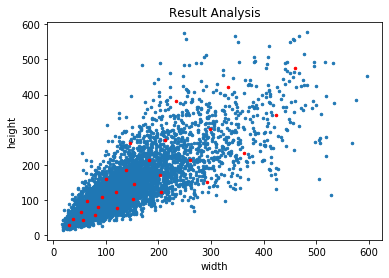

In [7]:
hw = np.array([pos_h, pos_w]).T
base_h,base_w = knnSeekAnchor(hw,iter_num=100,anchor_num=27)
draw_distribution(pos_w,pos_h,base_w,base_h)
anchor_size = np.vstack((base_w,base_h)).T

In [11]:
"""
def generate_anchor(anchor_size):

    #生成单个bin的anchor 即 shape = （anchornum, 4）
    
    base_size = anchor_info["base_size"]
    base_anchor = np.array([0, 0, base_size, base_size]).reshape(1, -1)
    scale = np.array(anchor_info["scale"]).reshape(-1, 1)
    scale_anchor = base_anchor * scale
    anchor = np.zeros(shape=(0, 4))
    ratio = np.array(anchor_info["ratio"])
    for r in ratio:
        anchor = np.vstack((anchor, np.stack((scale_anchor[:, 0],
                                              scale_anchor[:, 1],
                                              scale_anchor[:, 2] / np.sqrt(r),
                                              scale_anchor[:, 3] * np.sqrt(r)), axis=1)))
    w = anchor[:, 2]
    h = anchor[:, 3]
    anchor = np.stack((-w / 2, -h / 2, w / 2, h / 2), axis=1)
    return anchor
generate_anchor(anchor_size)
"""